## <span style="color:purple"> Games Analysis (Fundamental Algorithms Project) </span>

**Authors: Julie Helmers and Shasha Lin**

Due April 30, 2018

### <span style="color:green"> Idea of the game: </span>
The game in question is a classic zero-sum, minimax game. Paul is the maximizing agent and always has the first move; Carole is the minimizing agent. Both agents try to get the optimal value while anticipating the other agent's next move to optimize in the opposite direction.

### <span style="color:green"> Implementation: </span>
The game is implemented through a simple tree class, with each node having a left and right method, indicating the selection of 0 or 1 for the move to go to the next level. All nodes have a value attribute, which is the value of the game to Paul at that point, assuming both the maximizing and minimizing agents play rationally. Values are computed through a modified DFS_visit algorithm. (We implemented both a vanilla version and a sped-up version with alpha-beta pruning.)

**Note**: We implemented the tree class as a list of lists — each level of the tree is a list of nodes. We later realized that this is a painfully slow implementation, and we wish that we had implemented the tree with a dictionary instead. (See section 7 for more discussion of this issue.) 

### <span style="color:green"> Vanilla DFS_visit versus DFS_visit_fast through <i>alpha-beta pruning</i></span>:
1. DFS_visit naively visits the left and right children of each node, while alternating whether it is Paul's or Carole's turn to move (with a boolean Paul flag). DFS_visit only computes the value of a node if both values at its left and right child nodes have already been computed. If it is Paul's move, the node value is the maximum of its children's values; if Carole's, the minimum.
2. DFS_visit_fast uses <i>alpha-beta pruning</i> to avoid inspecting some paths in the search, therefore saving running time. During the algorithm, we keep track of two additional variables, alpha and beta. When we are inspecting a particular node on Paul's turn, the alpha value is the lower bound for the value Paul can get by taking a path that includes the current node, while the beta value is the upper bound for the value Carole can get by taking a path that includes the node's sibling instead. If alpha is bigger than beta, we know that on the previous level in the tree, Carole will move to the sibling node rather than the current node, and therefore we can stop running DFS_visit at this current node, as it will never be visited in the game. Symmetric logic applies when it's Carole's move.

### I. Build Tree Class

#### Setup

In [1]:
from __future__ import division
import numpy as np
import time
import math
import sys
from scipy import stats
import matplotlib.pyplot as plt
% matplotlib inline

# Correctly represent infinity depending on python version
if sys.version_info[0] >= 3:
    inf = math.inf
else:
    inf = float("inf")

#### Game Graph Class

In [2]:
# Node class
class node:
    '''A simple node in a binary tree'''
    def __init__(self, value=None, left=None, right=None, parent=None):
        self.value = value
        self.left = left
        self.right = right
        self.parent = parent

# Naive implementation        
def make_children(source):
    '''Creates and returns left and right children for source node'''
    left = node(parent=source)
    right = node(parent=source)
    source.left = left
    source.right = right
    return left, right

def make_tree(n):
    '''Builds a tree of depth n'''
    source = node()
    tree = [[] for i in range(n+1)]  # i is depth
    tree[0].append(source)
    # Add children depth-by-depth
    for i in range(n):
        for j in range(pow(2, i)):
            tree[i+1]+=make_children(tree[i][j])
    # Compute random leaf values
    for leaf in tree[-1]:
        leaf.value = 2*np.random.random()-1
    return tree
    
# Utility functions
def print_tree(tree):
    '''Prints value of all nodes in tree by depth'''
    for depth, level in enumerate(tree):
        vals = [v.value for v in level]
        print('Depth {} has {} nodes: {}'.format(depth, len(vals), vals))
    print('')

def get_value(tree):    
    '''Returns value of root node'''
    return tree[0][0].value
    
def print_value(tree):
    '''Prints value of root node'''
    print('The value to the first player, Paul, is: {}'.format(get_value(tree)))

#### DFS_visit for value calculation

In [3]:
def DFS_visit(tree, depth=0, key=0, Paul=True):
    '''Computes the value for each node'''
    current_node = tree[depth][key]
    if not current_node.value:
        DFS_visit(tree, depth+1, 2*key, Paul=not Paul)  # Left
        DFS_visit(tree, depth+1, 2*key+1, Paul=not Paul)  # Right
        
        left_child = tree[depth+1][2*key]
        right_child = tree[depth+1][2*key+1]
        
        if left_child.value:
            if right_child.value:
                if Paul:  # Maximizing player
                    current_node.value = max(left_child.value, right_child.value)
                else:  # Minimizing player
                    current_node.value = min(left_child.value, right_child.value)   

def DFS_visit_fast(tree, depth=0, key=0, alpha=-inf, beta=inf, Paul=True):
    '''Computes the values for nodes with alpha-beta pruning to limit search'''
    current_node = tree[depth][key]
    if not current_node.value:
        left_child = tree[depth+1][2*key]
        right_child = tree[depth+1][2*key+1]

        if Paul:  # Maximizing player
            v = -inf
            
            # Left
            DFS_visit_fast(tree, depth+1, 2*key, alpha, beta, Paul=not Paul)
            v = max(v, left_child.value)
            alpha = max(alpha, v)
            
            # Right
            if beta > alpha:
                DFS_visit_fast(tree, depth+1, 2*key+1, alpha, beta, Paul=not Paul)
                v = max(v, right_child.value)
                alpha = max(alpha, v)
            
        else:  # Minimizing player
            v = inf
            
            # Left
            DFS_visit_fast(tree, depth+1, 2*key, alpha, beta, Paul=not Paul)
            v = min(v, left_child.value)
            beta = min(beta, v)
            
            # Right
            if beta > alpha:
                DFS_visit_fast(tree, depth+1, 2*key+1, alpha, beta, Paul=not Paul)
                v = min(v, right_child.value)
                beta = min(beta, v)

        current_node.value = v

#### Example
We first test our implementation of the game on a tree of depth 20. We use vanilla DFS_visit and DFS_visit_fast (the alpha-beta pruning version) to compute the value for Paul, checking that the values are indeed the same and that we are actually saving time with DFS_visit_fast.

In [4]:
# Example tree:
n = 20
example = make_tree(n)


t0 = time.time()
example = make_tree(n)
leaves = example[-1]
t1 = time.time()

# Example calculation with vanilla DFS_visit:                 
t0 = time.time()
DFS_visit(example)
t1 = time.time()
print('Time to compute values for tree of depth %d without \
alpha-beta pruning: %.2f sec'%(n, t1 - t0))
print('The value at root node computed using vanilla DFS_visit is: %.2f\
      \n'%get_value(example))


# Example calculation with alpha-beta DFS_visit, checking that value at
# root node is the same:    
example = make_tree(n)
example[-1] = leaves  
t3 = time.time()
DFS_visit_fast(example)
t4 = time.time()
print('Time to compute values for tree of depth %d with \
alpha-beta pruning: %.2f sec, it only took %.2f%% of the time \
for vanilla version'%(n, t4 - t3, 100*(t4 - t3)/(t1-t0)))
print('The value at root node computed using DFS_visit with \
alpha-beta pruning is: %.2f'%get_value(example))

Time to compute values for tree of depth 20 without alpha-beta pruning: 1.43 sec
The value at root node computed using vanilla DFS_visit is: -0.24      

Time to compute values for tree of depth 20 with alpha-beta pruning: 0.16 sec, it only took 11.27% of the time for vanilla version
The value at root node computed using DFS_visit with alpha-beta pruning is: -0.24


### II. Data Scientist Hat is On: 
### Simulations

#### 1. Is there an advantage to playing last? Test the effect of parity of tree depth.

We build 100 trees of even number depth, with depth uniformly distributed in {10, 12, 14, 16, 18}. To make the comparison a level playing field, we randomly add either +1 or -1 to these even numbers to create 100 trees of odd number depths in {9, 11, 13, 15, 17, 19}. We use DFS_visit_fast to compute the value of the game for each tree, and do a two-sample t-test on the 100 values from the odd depth trees and even depth trees. As can be seen below, the p-value from this t-test is well below 1e-3, which gives us plenty of confidence to reject the null hypothesis that the parity of tree depth does not influence game results. We found the average value for 100 odd depth trees to be 0.25 (Paul wins), whereas the value for 100 even depth trees was -0.23 (Carole wins): We conclude that the **last person** to play is much more likely to **win** this game (which is befitting the player who is named CAROLE after ORACLE). 

In [5]:
# Create the lists of even and odd depths to use
ks = np.random.randint(5, 10, 100)
even_numbers = 2*ks
plus_or_minus = np.random.choice((1, -1), 100)
odd_numbers = even_numbers + plus_or_minus

# Build the trees
even_trees = [make_tree(n) for n in even_numbers]
odd_trees = [make_tree(n) for n in odd_numbers]

# Compute values for the trees
for tree in even_trees + odd_trees:
    DFS_visit_fast(tree)
    
odd_values = [get_value(tree) for tree in odd_trees]
even_values = [get_value(tree) for tree in even_trees]
print('Mean value to Paul for odd trees: {}\nMean value to Paul for even trees: {}'.format(np.mean(odd_values), np.mean(even_values)))
stats.ttest_ind(odd_values, even_values, equal_var=False)

Mean value to Paul for odd trees: 0.24622146563976577
Mean value to Paul for even trees: -0.2264064881952218


Ttest_indResult(statistic=63.999362721286055, pvalue=1.2313746223433823e-132)

#### 2. Is there an advantage to playing first? Test the difference from zero. 

For this question, we simply pull together the values from all the odd depth trees and even depth trees from the previous question (a total of 200 trees with depth between 9 and 19), and compare their average value with zero. We found the mean to be 0.01, which generates an insignificant p-value (0.56). We cannot reject the null hypothesis, and therefore conclude that there is **no evidence** of an advantage to playing first. 

In [6]:
values = odd_values + even_values
print('Mean value to Paul for odd and even trees: {}'.format(np.mean(values)))
stats.ttest_1samp(values, popmean=0)

Mean value to Paul for odd and even trees: 0.009907488722272007


Ttest_1sampResult(statistic=0.57762964033360942, pvalue=0.56416717508374292)

#### 3 & 4: Is there much variance in the results? Is there a distribution to the results?

We take n = {13, 14, 15, 16} and make 100 randomly initialized trees for each. (Since the distribution is probably different for odd and even trees, we decided to run experiments separately for odd and even depths.) The variances are printed below — we conclude that for a reasonably large n, the variance is small, in the sense that zero is more than 5 standard deviations away from the mean — Paul wins odd depth games with very high probability, and Carole wins even depth games with high probability (in fact, in our simulation, the frequency is 100%). 

In [3]:
def get_moments(n):
    ns = [n]*100
    trees = [make_tree(n) for n in ns]
    for tree in trees:
        DFS_visit_fast(tree)
    values = [get_value(tree) for tree in trees]
    mean = np.mean(values)
    var = pow(np.std(values), 2)
    print('With depth of %d, the average value for Paul is: %.2f, \
    the variance is: %.5f' % (n, mean, var))
    return values, mean, var

In [5]:
values13, mean13, var13 = get_moments(13)
values14, mean14, var14 = get_moments(14)
values15, mean15, var15 = get_moments(15)
values16, mean16, var16 = get_moments(16)

With depth of 13, the average value for Paul is: 0.26,     the variance is: 0.00254
With depth of 14, the average value for Paul is: -0.23,     the variance is: 0.00179
With depth of 15, the average value for Paul is: 0.25,     the variance is: 0.00104
With depth of 16, the average value for Paul is: -0.23,     the variance is: 0.00088


We use a histogram to investigate the distribution of the results. For the n's we experimented on (from 13 to 16), the distribution is negatively skewed for even n's, and positively skewed for odd ones. 

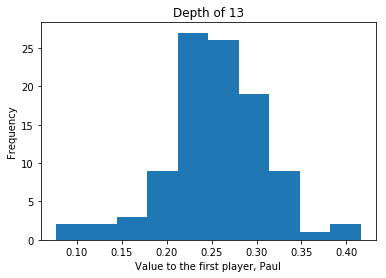

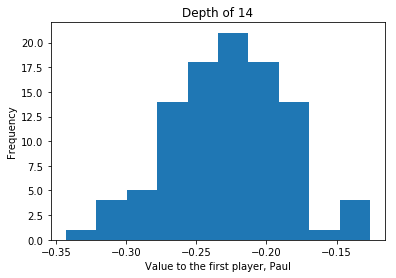

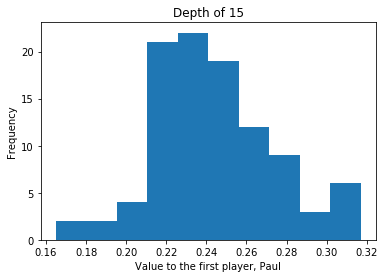

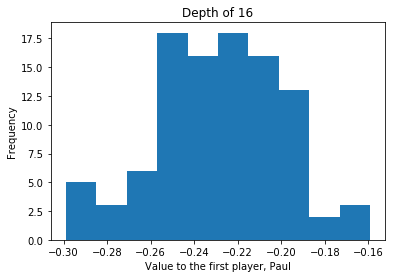

In [8]:
def empirical_distribution(depth, values):
    n, bins, patches = plt.hist(values, bins=10)
    plt.xlabel('Value to the first player, Paul')
    plt.ylabel('Frequency')
    plt.title('Depth of %d' % depth)
    plt.show()

empirical_distribution(13, values13)        
empirical_distribution(14, values14)    
empirical_distribution(15, values15)
empirical_distribution(16, values16)

Theoretically, there is a closed form probability density function to this distribution: We know that the minimum of two values generated i.i.d from [0, 1) follows a $Beta(1, 2)$ distribution, and the maximum follows $Beta(2, 1)$. Initializing the values at x ~ $Uniform([-1, 1))$ means y=$\frac{x+1}{2}$ ~ $Beta$ distribution. By substituting y with $\frac{x+1}{2}$ in the cdf of $Beta(2, 1)$, we get $F(y)  = I_x(2, 1) = y^2$. We can get the cdf of the values at n-1 depth for odd n's: $F(x) = \frac{(x+1)^2}{4}$. The derivative of $F(x)$ is $\frac{x+1}{2}$, which is the pdf of values at a depth of n-1.

At a depth of n-2, we can get the pdf and cdf of the values from order statistics: The minimum element from 2 i.i.d. samples drawn from distribution with pdf $f(x)$ and cdf $F(x)$ follows the distribution with pdf $f'(x) = 2f(x)(1-F(x))$, and cdf $F'(x) = 1 - (1-F(x))^2$. At a depth of n-3, we then use the formula for the pdf and cdf of the maximum element drawn from i.i.d. samples with pdf $f'(x)$, $F'(x)$: $f''(x) = 2f'(x)F'(x)$, $F''(x) = F'(x)^2$... And so on.

For even n's , we can do similar calculations for each level, from the bottom up. 

The pdf and cdf get more and more intricate with more levels, so we weren't able to write out the distribution for large n. However, we can test that this iterative method gets the correct pdf for the distribution, using depth 3 as an example. We plot the distribution of 10000 simulations together with the distribution obtained through the method above. As can be seen below, the pdf calculated with the above method fit well with the normalized frequencies from simulations.

With depth of 3, the average value for Paul is: 0.32,     the variance is: 0.12277


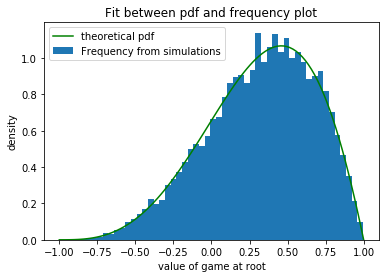

In [65]:
def get_moments(n):
    ns = [n]*10000
    trees = [make_tree(n) for n in ns]
    for tree in trees:
        DFS_visit_fast(tree)
    values = [get_value(tree) for tree in trees]
    mean = np.mean(values)
    var = pow(np.std(values), 2)
    print('With depth of %d, the average value for Paul is: %.2f, \
    the variance is: %.5f' % (n, mean, var))
    return values, mean, var

##calculate density##
from scipy.stats import beta
x = np.linspace(-1, 1, 100)
y = (x+1)/2
#depth 3-1, maximize of i.i.d distributed values
depth2_cumulative_density = pow(y,2) #cdf for beta(2, 1) is F(x) = x^2
depth2density = (x+1)/2#derivate of depth2_cumulative_density w.r.t. x
#depth 3-2, minimize of i.i.d distributed values
depth3density = 2*depth2density*(1-depth2_cumulative_density)
from functools import partial
depth3_cumlative_density = 1 - np.array(list((map(lambda x: pow(x, 2), (1-depth2_cumulative_density)))))
#depth 3-3, maximize of i.i.d distributed values
root_density = 2*depth3density*depth3_cumlative_density

##simulations##
value3, mean3, var3 = get_moments(3)

##plotting##
fig,ax = plt.subplots(1)
ax.plot(x, root_density, label = 'theoretical pdf', color='green')
n, bins, patches = plt.hist(value3, density=True, label='Frequency from simulations', bins=50)
ax.legend(loc='upper left')
ax.set_xlabel('value of game at root')
ax.set_ylabel('density')
ax.set_title('Fit between pdf and frequency plot')
plt.show()

#### 5. What does the limiting behavior as n → ∞ appear to be?

To look at the asymptotics, we build a large tree (depth n = 25 or 26, the largest depths permitted by limited time and computing power for this project). We then plot the average of the values at even layers of the tree. When layer i = 2, 4, 6, ..., it's always Paul's move, therefore the value at such a level can be treated as the value of the game to Paul for a tree of depth n-i. We create one plot for n=25 to analyze the asymptotic value for $n\longrightarrow \infty$ when n is odd, and another plot for n=26 to analyze the asymptotic value for $n\longrightarrow \infty$ when n is even. From the plots, we can see that for even trees, the value converges to -0.23 as n grows large; for odd trees, the value converges to 0.24 as n grows large.  

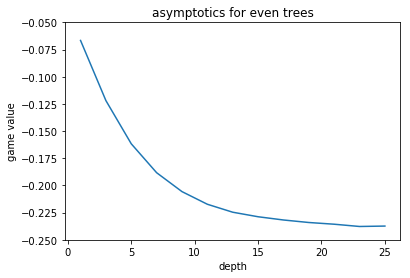

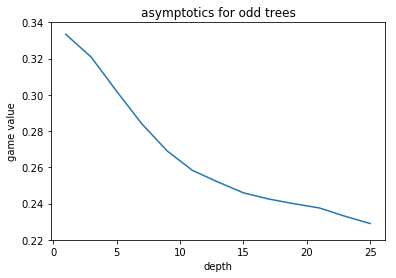

In [ ]:
def plot_asymptotics(depth):
    large_tree = make_tree(depth)
    DFS_visit(large_tree)
    average_values = []
    if not depth%2:
        deepest = depth -1
    else:
        deepest = depth
    for i in range(0, deepest, 2):
        values = [large_tree[i][j].value for j in range(pow(2, i))]
        average_values.append(np.mean(values))
    
    fig,ax = plt.subplots(1)
    plt.plot(list(range(deepest, 0, -2)), average_values)
    ax.set_title('asymptotics for %s trees'%('odd' if depth%2 else 'even'))
    ax.set_xlabel('depth')
    ax.set_ylabel('game value')
    if not depth%2:
        ax.set_ylim(-.25, -.05)
    else:
        ax.set_ylim(.22, .34)
    plt.show()
        
plot_asymptotics(26)        
plot_asymptotics(25)                  

#### 6.  Alpha-beta pruning time analysis
We want to see how much time, on average, alpha-beta pruning saves us, as compared to the vanilla DFS_visit algorithm. We record the time taken to calculate trees of depth from 1 up to 22 for vanilla DFS_visit and DFS_visit_fast, and plot them. Theoretically, DFS_visit runs in $O(2^n)$, where n is the number of moves in the game, whereas alpha-beta pruning runs in $O(2^{n/2})$. In our implementation, the speed-up is not quite $O(2^{n/2})$ — we discuss the reason in the next section. 

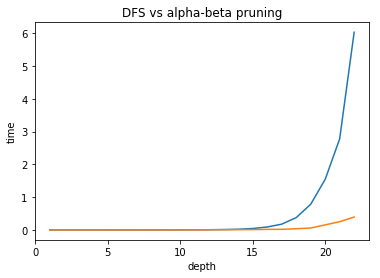

In [4]:
def get_time(depth,alg):
    times = []
    for i in range(1, depth+1):
        tree = make_tree(i)
        time0 = time.time()
        alg(tree)
        time1 = time.time()
        times.append(time1 - time0)
    return times

depth = 22
DFS_times = get_time(depth, DFS_visit)
alpha_beta_times = get_time(depth, DFS_visit_fast)
fig, ax = plt.subplots(1)
ax.plot(list(range(1, depth+1)), DFS_times, label='regular DFS')
ax.plot(list(range(1, depth+1)), alpha_beta_times, label='alpha-beta pruning')
ax.set_xlabel('depth')
ax.set_ylabel('time')
ax.set_title('DFS vs alpha-beta pruning')
plt.show()

#### 7.  <span style="color:blue"> Reflections on our implementation — man oh man do we wish we'd thought for a second longer before coding! </span>
Theoretically, alpha-beta speed up changes the run time from $O(2^n)$ to $O(2^{n/2})$ in the best case scenario, and close to $O(2^{n/2})$ in the average case: DFS_visit_fast for a tree of depth 20 should take about the same time as vanilla DFS_visit for a tree of depth 10. However, from the above graph we can see that we are not saving as much time — our vanilla DFS_visit runs for about depth 16 in the same time as DFS_visit_fast for depth 20. We also noticed how slow the tree building generally is, and the Jupyter notebook python kernel cannot survive any depth bigger than 27 with our implementation of the tree class. We reviewed the assignment and noticed the hint of using binary code as the key for positions in the tree, instead of having an actual node class and tree class implemented with python lists. In our implementation, a tree is a list of lists, with each level in the tree being a list of node objects. When we run make_tree and DFS_visit or DFS_visit_fast, the majority of the time is spent expanding/searching the list and accessing the list elements, which takes time $O(n)$, where n is the length of the list. Had we implemented the tree as a dictionary instead, where the keys were binary strings indicating the position in the tree, and the values were the values for Paul at that position, we would have had $O(1)$ lookups. In this way, most of the time in a call to DFS_visit or DFS_visit_fast would be spent on static evaluations at the leaf level, instead of searching lists, and we would see performance comparisons closer to the theoretical level.